In [1]:
from data_utils import get_prepared_data
import pandas as pd

# df = get_prepared_data()

# df.to_csv('prepared_data.csv', index=False) 
df = pd.read_csv('prepared_data.csv')  

**Split into train and test sets**

In [2]:
from sklearn.model_selection import train_test_split

pcodes = list(df["pcode"])
df = df.drop("pcode", axis=1)

y_columns = ['valence', 'arousal', 'attention', 'stress']
X = df.drop(y_columns, axis=1)
y = df[y_columns]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

**Logistic Regression**

In [3]:
import numpy as np
from mord import LogisticIT  # LogisticIT is for immediate-threshold ordinal regression
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score
from model_utils import get_metrics, plot_model_comparison

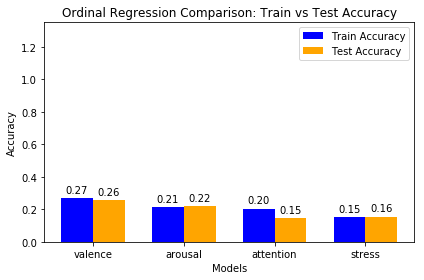

In [4]:
ordinal_train_acc = []
ordinal_test_acc = []

# Train a model for each output (valence, arousal, attention, stress)
for i, target in enumerate(y_columns):
    # Create and train the ordinal regression model
    ordinal_model = LogisticIT()
    ordinal_model.fit(X_train, y_train[target])

    test_preds = ordinal_model.predict(X_test)
    train_preds = ordinal_model.predict(X_train)
    train_accuracy, test_accuracy = get_metrics(train_preds, y_train[target], test_preds, y_test[target])
    ordinal_train_acc.append(train_accuracy)
    ordinal_test_acc.append(test_accuracy)

plot_model_comparison("Ordinal Regression", y_columns, ordinal_test_acc, ordinal_train_acc)


**Random Forest Classifier**

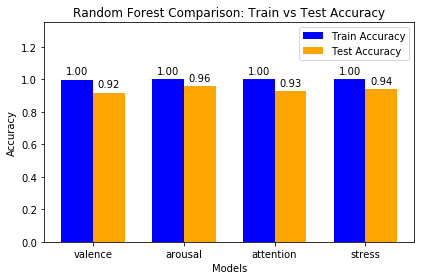

In [5]:
from sklearn.ensemble import RandomForestClassifier

rf_train_acc = []
rf_test_acc = []

# Train a model for each output (valence, arousal, attention, stress)
for i, target in enumerate(y_columns):
    # Create and train the ordinal regression model
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train[target])

    test_preds = rf_model.predict(X_test)
    train_preds = rf_model.predict(X_train)
    train_accuracy, test_accuracy = get_metrics(train_preds, y_train[target], test_preds, y_test[target])
    rf_train_acc.append(train_accuracy)
    rf_test_acc.append(test_accuracy)

plot_model_comparison("Random Forest", y_columns, rf_test_acc, rf_train_acc)


**Neural Net**

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

inputs = layers.Input(shape=X_train.shape[1])

m = layers.Dense(256, activation='relu')(inputs)
m = layers.Dropout(0.2)(m)
m = layers.Dense(128, activation='relu')(m)
m = layers.Dropout(0.2)(m)
m = layers.Dense(32, activation='relu')(m)

valence_output = layers.Dense(7, activation='softmax', name='valence')(m)
arousal_output = layers.Dense(7, activation='softmax', name='arousal')(m)
attention_output = layers.Dense(7, activation='softmax', name='attention')(m)
stress_output = layers.Dense(7, activation='softmax', name='stress')(m)

model = models.Model(inputs=inputs, outputs=[valence_output, arousal_output, attention_output, stress_output])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],

)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 16)]         0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 256)          4352        input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 256)          0           dense_3[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          32896       dropout_2[0][0]                  
____________________________________________________________________________________________

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Add 3 to convert to 0 to 6 instead of -3 to 3
y_train_valence = y_train['valence'].values + 3
y_train_arousal = y_train['arousal'].values + 3
y_train_attention = y_train['attention'].values + 3
y_train_stress = y_train['stress'].values + 3

y_test_valence = y_test['valence'].values + 3
y_test_arousal = y_test['arousal'].values + 3
y_test_attention = y_test['attention'].values + 3
y_test_stress = y_test['stress'].values + 3


In [16]:
from model_utils import plot_training_history

history = model.fit(
    X_train_scaled,
    {
        'valence': y_train_valence,
        'arousal': y_train_arousal,
        'attention': y_train_attention,
        'stress': y_train_stress
    },
    epochs=125,
    batch_size=64,
    validation_split=0.2
)

Train on 729 samples, validate on 183 samples
Epoch 1/125
729/729 [==============================] - 0s 437us/sample - loss: 3.8552 - valence_loss: 0.9324 - arousal_loss: 0.9801 - attention_loss: 0.9497 - stress_loss: 0.9410 - valence_acc: 0.6255 - arousal_acc: 0.6351 - attention_acc: 0.6722 - stress_acc: 0.6735 - val_loss: 5.9192 - val_valence_loss: 1.5064 - val_arousal_loss: 1.4727 - val_attention_loss: 1.4850 - val_stress_loss: 1.4601 - val_valence_acc: 0.4153 - val_arousal_acc: 0.4536 - val_attention_acc: 0.5410 - val_stress_acc: 0.4918
Epoch 2/125
729/729 [==============================] - 0s 358us/sample - loss: 3.7552 - valence_loss: 0.9128 - arousal_loss: 0.9472 - attention_loss: 0.9383 - stress_loss: 0.9501 - valence_acc: 0.6447 - arousal_acc: 0.6488 - attention_acc: 0.6529 - stress_acc: 0.6571 - val_loss: 5.8940 - val_valence_loss: 1.5119 - val_arousal_loss: 1.4405 - val_attention_loss: 1.4713 - val_stress_loss: 1.4603 - val_valence_acc: 0.4098 - val_arousal_acc: 0.4590 - val

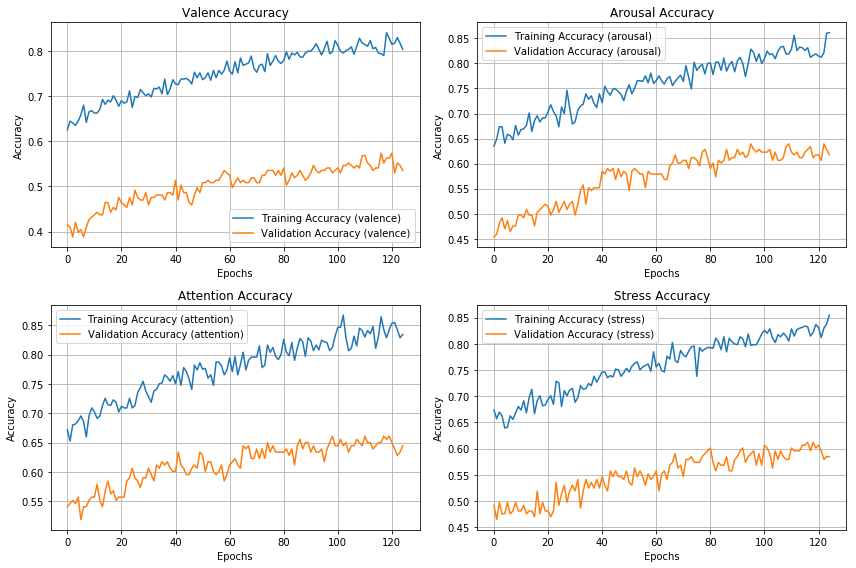

In [17]:
plot_training_history(history=history)

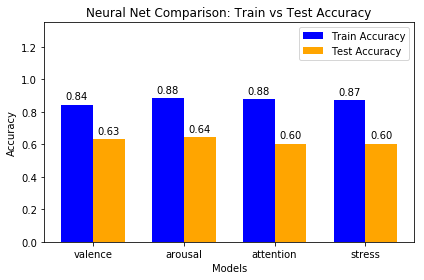

In [18]:
nn_train_acc = []
nn_test_acc = []

# Train a model for each output (valence, arousal, attention, stress)
for i, target in enumerate(y_columns):
    model.predict(X_test_scaled)

    # Subtract 3 to convert back to 0 to 6
    test_preds = np.argmax(model.predict(X_test_scaled)[i], axis=1) - 3
    train_preds = np.argmax(model.predict(X_train_scaled)[i], axis=1) - 3

    train_accuracy, test_accuracy = get_metrics(train_preds, y_train[target], test_preds, y_test[target])
    nn_train_acc.append(train_accuracy)
    nn_test_acc.append(test_accuracy)

plot_model_comparison("Neural Net", y_columns, nn_test_acc, nn_train_acc)
